In [1]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget
import gc

# temp - needed for SHL split
from sklearn.model_selection import train_test_split

In [2]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [3]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')



In [4]:
import load_data_utils as utils # ldu just seemed confusing!
print('My env_info: \n' + utils.get_env_info()) # using + vs , gets rid of space

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: 


In [5]:
def get_dataset(dataset):
    if (dataset == 'MobiAct HAR'):
        if (os.path.exists('MobiAct_Dataset_v1.0.zip')):
            print ("Local MobiAct zip found, skipping download")
        else:
            !gdown "1kt9wtIt7N7SIFQAbav7zcZ_PqTa5HegA&confirm=t" # MobiAct alternate file source
        # original share is https://drive.google.com/uc?id=0B5VcW5yHhWhibWxGRTZDd0dGY2s'
        # please see https://bmi.hmu.gr/the-mobifall-and-mobiact-datasets-2/ if not working
        get_py_file(fname = 'mobiact_adl_load_dataset.py',
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/MobiAct/mobiact_adl_load_dataset.py')
        from mobiact_adl_load_dataset import mobiact_adl_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
        k_size = 50
        EPOCHS = 50
        t_names = ['JOG','JUM','STD','STN','STU','WAL']
    elif (dataset == 'UniMiB SHAR'):
        get_py_file(fname = 'unimib_adl_load_dataset.py',
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UniMiB_SHAR/unimib_shar_adl_load_dataset.py')
        from unimib_adl_load_dataset import unimib_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
        t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
        k_size = 50
        EPOCHS = 20
    elif (dataset == 'UCI HAR'):
        get_py_file(fname = 'uci_har_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/UCI_HAR/uci_har_load_dataset.py')
        from uci_har_load_dataset import uci_har_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
        t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
        k_size = 50
        EPOCHS = 30
    elif (dataset == 'TWristAR'):
        # Note TWristAR is more updated than the previous datasets so the accesses
        # and defaults are a bit different, e.g. t_names is pulled from the .py
        get_py_file(fname = 'twristar_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')
        import twristar_load_dataset as twristar_load_dataset # diff to get label map
        x_train, y_train, x_valid, y_valid, x_test, y_test \
                                = twristar_load_dataset.twristar_load_dataset(
                                    incl_val_group = True,
                                    one_hot_encode = True)
        t_names = list(twristar_load_dataset.label_map_twristar.get('label').keys())
        t_names.remove('Undefined')
        k_size = 16
        EPOCHS = 20
    elif (dataset == 'Leotta_2021'):
        get_py_file(fname = 'leotta_2021_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/ADL/Leotta_2021/leotta_2021_load_dataset.py')
        #full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
        #shutil.copy(full_filename,'leotta_2021_load_dataset.py')

        import leotta_2021_load_dataset as leotta_2021_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = leotta_2021_load_dataset.leotta_2021_load_dataset(incl_val_group = True, one_hot_encode = True)
        t_names = list(leotta_2021_load_dataset.label_map_leotta.get('label').keys())
        k_size = 100
        EPOCHS = 50
    elif (dataset == 'SHL'):
        # SHL takes about 30 minutes to process due to size, using saved arrays for now
        !gdown "1ApHVQ-P2reO6ctNVxeHHxCHeoNlp6c9P&confirm=t" # SHL 20Hz
        utils.unzip_into_dir('SHL_20hz_for_gentry.zip','SHL')
        input_dir = './SHL'
        x_train = np.load(input_dir + '/'+'x_train.npy')
        x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
        x_test = np.load(input_dir + '/'+'x_test.npy')
        x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
        y_train = np.load(input_dir + '/'+'y_train.npy')
        y_test = np.load(input_dir + '/'+'y_test.npy')
        # also don't have validate working in SHL so just using stratify
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

        t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
        k_size = 15
        EPOCHS = 100
    elif (dataset == 'Gesture Phase Segmentation'):
        get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py',
                    url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
        from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                                = gesture_phase_segmentation_load_dataset(
                                    incl_val_group = True,
                                    return_info_dict = True)
        print("Note: Due to the size of the Gesture Phase Segmentation and for",
            "\ncompatibility, the test arrays are copies of the valid arrays")
        x_test = x_valid.copy()
        y_test = y_valid.copy()
        t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
        k_size = 9
        EPOCHS = 30
    else:
        print('ERROR: dataset unknown')
    print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                    'x_valid':x_valid,'y_valid':y_valid,
                                    'x_test':x_test,'y_test':y_test}))
    return x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names


In [6]:
ds_list = ["UniMiB SHAR",
           "UCI HAR",
           "TWristAR",
           "Leotta_2021",
           "Gesture Phase Segmentation"
           ]


In [7]:
def modelCNN(x_train, y_train, k_size):
	n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
	model = keras.Sequential(
		[
			keras.Input(shape=(n_timesteps,n_features)),
			layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
			layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
			layers.Dropout(0.5),
			layers.MaxPooling1D(pool_size=2),
			layers.Flatten(),
			layers.Dense(100, activation='relu'),
			layers.Dense(n_outputs, activation='softmax')
   		]
	)
	return model

In [8]:
def train_model(model, x_train, y_train, x_valid, y_valid,
    BATCH_SIZE ,    # Typical values are 8, 16 or 32
    NUM_EPOCHS ): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=7)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=(x_valid,y_valid),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

In [9]:
def run_model(model, x_test):
    predictions = model.predict(x_test, verbose = 0, batch_size = 64)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    probabilities = np.exp(predictions) / np.sum(np.exp(predictions), axis=-1, keepdims=True)
    return y_pred, probabilities


**** Processing  UniMiB SHAR  ****
Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)
array    shape           data type
-------  -----------

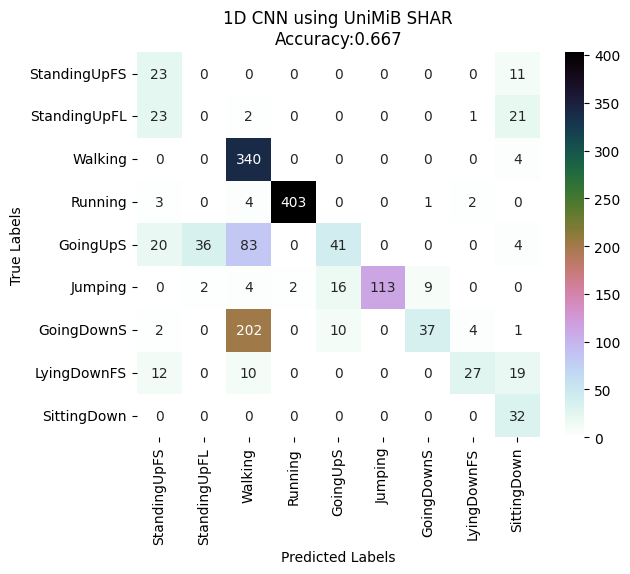

Prediction accuracy: 0.667
              precision    recall  f1-score   support

StandingUpFS       0.28      0.68      0.39        34
StandingUpFL       0.00      0.00      0.00        47
     Walking       0.53      0.99      0.69       344
     Running       1.00      0.98      0.99       413
    GoingUpS       0.61      0.22      0.33       184
     Jumping       1.00      0.77      0.87       146
  GoingDownS       0.79      0.14      0.24       256
 LyingDownFS       0.79      0.40      0.53        68
 SittingDown       0.35      1.00      0.52        32

    accuracy                           0.67      1524
   macro avg       0.59      0.58      0.51      1524
weighted avg       0.74      0.67      0.63      1524

**** Processing  UCI HAR  ****
Unzipping UCI_HAR_Dataset.zip file

The validation group is generated using sklearn stratify on train
It is not subject independent - confirm accuracy with test set
array    shape           data type
-------  --------------  -----------


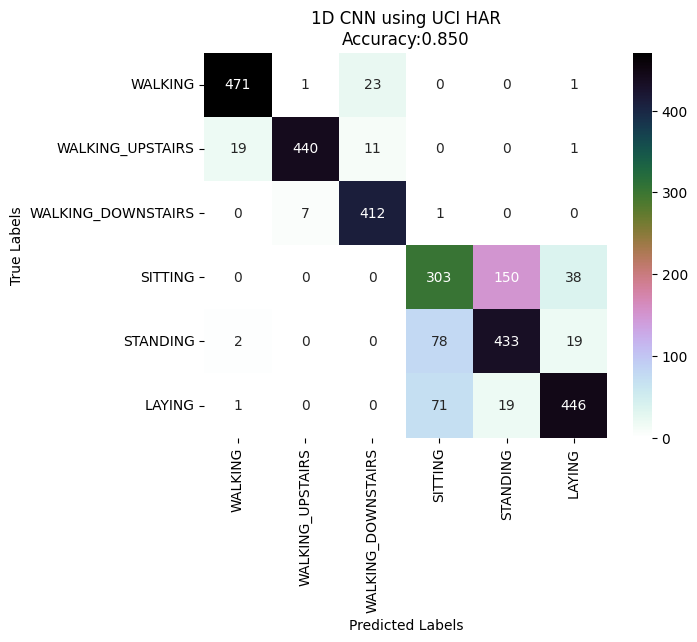

Prediction accuracy: 0.850
                    precision    recall  f1-score   support

           WALKING       0.96      0.95      0.95       496
  WALKING_UPSTAIRS       0.98      0.93      0.96       471
WALKING_DOWNSTAIRS       0.92      0.98      0.95       420
           SITTING       0.67      0.62      0.64       491
          STANDING       0.72      0.81      0.76       532
            LAYING       0.88      0.83      0.86       537

          accuracy                           0.85      2947
         macro avg       0.86      0.85      0.85      2947
      weighted avg       0.85      0.85      0.85      2947

**** Processing  TWristAR  ****
Unzipping TWristAR file in . directory
90/10 split of the training group.  It is not subject independent.
array    shape          data type
-------  -------------  -----------
x_train  (1869, 96, 1)  float32
y_train  (1869, 6)      uint8
x_valid  (208, 96, 1)   float32
y_valid  (208, 6)       uint8
x_test   (1091, 96, 1)  float32
y_test

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


117/117 [==============================] - 7s 50ms/step - loss: 0.9146 - accuracy: 0.5639 - val_loss: 0.5553 - val_accuracy: 0.7404
Epoch 2/20
117/117 [==============================] - 4s 38ms/step - loss: 0.5229 - accuracy: 0.7266 - val_loss: 0.4750 - val_accuracy: 0.7740
Epoch 3/20
117/117 [==============================] - 5s 40ms/step - loss: 0.3934 - accuracy: 0.8004 - val_loss: 0.4257 - val_accuracy: 0.7644
Epoch 4/20
117/117 [==============================] - 5s 45ms/step - loss: 0.3621 - accuracy: 0.7924 - val_loss: 0.3872 - val_accuracy: 0.7885
Epoch 5/20
117/117 [==============================] - 4s 38ms/step - loss: 0.3213 - accuracy: 0.8101 - val_loss: 0.5009 - val_accuracy: 0.7308
Epoch 6/20
117/117 [==============================] - 6s 47ms/step - loss: 0.3435 - accuracy: 0.7961 - val_loss: 0.3746 - val_accuracy: 0.8029
Epoch 7/20
117/117 [==============================] - 6s 47ms/step - loss: 0.2954 - accuracy: 0.8127 - val_loss: 0.3958 - val_accuracy: 0.7740
Epoch 8/20

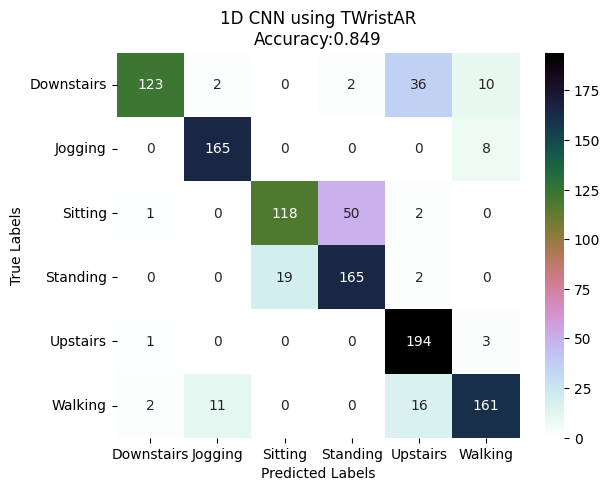

Prediction accuracy: 0.849
              precision    recall  f1-score   support

  Downstairs       0.97      0.71      0.82       173
     Jogging       0.93      0.95      0.94       173
     Sitting       0.86      0.69      0.77       171
    Standing       0.76      0.89      0.82       186
    Upstairs       0.78      0.98      0.87       198
     Walking       0.88      0.85      0.87       190

    accuracy                           0.85      1091
   macro avg       0.86      0.84      0.85      1091
weighted avg       0.86      0.85      0.85      1091

**** Processing  Leotta_2021  ****
Unzipping Leotta 2021 dataset into ./dataset
Using source file ./ADL_Leotta_2021.zip


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array    shape           data type
-------  --------------  -----------
x_train  (2391, 300, 3)  float32
y_train  (2391, 18)      uint8
x_valid  (1167, 300, 3)  float32
y_valid  (1167, 18)      uint8
x_test   (1987, 300, 3)  float32
y_test   (1987, 18)      uint8
Epoch 1/50
24/24 [==============================] - 48s 2s/step - loss: 2.4602 - accuracy: 0.1639 - val_loss: 2.1258 - val_accuracy: 0.3231
Epoch 2/50
24/24 [==============================] - 41s 2s/step - loss: 1.8100 - accuracy: 0.3639 - val_loss: 1.7444 - val_accuracy: 0.4207
Epoch 3/50
24/24 [==============================] - 41s 2s/step - loss: 1.2802 - accuracy: 0.5521 - val_loss: 1.4642 - val_accuracy: 0.5030
Epoch 4/50
24/24 [==============================] - 41s 2s/step - loss: 0.9129 - accuracy: 0.6893 - val_loss: 1.2954 - val_accuracy: 0.4893
Epoch 5/50
24/24 [==============================] - 46s 2s/step - loss: 0.7523 - accuracy: 0.7281 - val_loss: 1.2851 - val_accuracy: 0.5107
Epoch 6/50
24/24 [==================

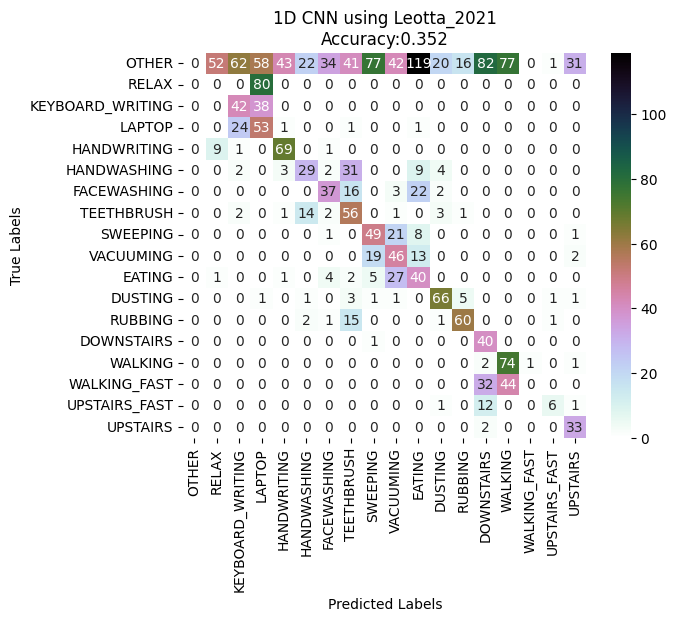

Prediction accuracy: 0.352
                  precision    recall  f1-score   support

           OTHER       0.00      0.00      0.00       777
           RELAX       0.00      0.00      0.00        80
KEYBOARD_WRITING       0.32      0.53      0.39        80
          LAPTOP       0.23      0.66      0.34        80
     HANDWRITING       0.58      0.86      0.70        80
     HANDWASHING       0.43      0.36      0.39        80
     FACEWASHING       0.45      0.46      0.46        80
      TEETHBRUSH       0.34      0.70      0.46        80
        SWEEPING       0.32      0.61      0.42        80
       VACUUMING       0.33      0.57      0.42        80
          EATING       0.19      0.50      0.27        80
         DUSTING       0.68      0.82      0.75        80
         RUBBING       0.73      0.75      0.74        80
      DOWNSTAIRS       0.24      0.98      0.38        41
         WALKING       0.38      0.95      0.54        78
    WALKING_FAST       0.00      0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Unzipping Gesture Phase Segmentation file in ./gesture_phase_dataset directory
Train: dict_keys(['a1_raw', 'a2_raw', 'a3_raw', 'b1_raw', 'b3_raw'])
Valid: dict_keys([])
Test : dict_keys(['c1_raw', 'c3_raw'])
90/10 split of the training group.  It is not subject independent.
Note: Due to the size of the Gesture Phase Segmentation and for 
compatibility, the test arrays are copies of the valid arrays
array    shape          data type
-------  -------------  -----------
x_train  (422, 30, 18)  float32
y_train  (422, 5)       float64
x_valid  (47, 30, 18)   float32
y_valid  (47, 5)        float64
x_test   (47, 30, 18)   float32
y_test   (47, 5)        float64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/30
47/47 [==============================] - 2s 13ms/step - loss: 1.4033 - accuracy: 0.5142 - val_loss: 1.0388 - val_accuracy: 0.7234
Epoch 2/30
47/47 [==============================] - 0s 9ms/step - loss: 0.8623 - accuracy: 0.6896 - val_loss: 0.7520 - val_accuracy: 0.7872
Epoch 3/30
47/47 [==============================] - 0s 8ms/step - loss: 0.7052 - accuracy: 0.7630 - val_loss: 0.7310 - val_accuracy: 0.7660
Epoch 4/30
47/47 [==============================] - 0s 9ms/step - loss: 0.6382 - accuracy: 0.7773 - val_loss: 0.8730 - val_accuracy: 0.7021
Epoch 5/30
47/47 [==============================] - 0s 9ms/step - loss: 0.7100 - accuracy: 0.7607 - val_loss: 0.7079 - val_accuracy: 0.7660
Epoch 6/30
47/47 [==============================] - 0s 9ms/step - loss: 0.5994 - accuracy: 0.7891 - val_loss: 0.6592 - val_accuracy: 0.8723
Epoch 7/30
47/47 [==============================] - 0s 9ms/step - loss: 0.6597 - accuracy: 0.7844 - val_loss: 0.8992 - val_accuracy: 0.6809
Epoch 8/30
47/47 [=

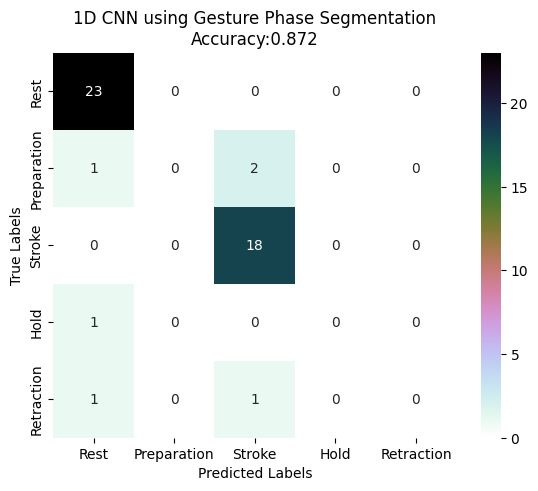

Prediction accuracy: 0.872
              precision    recall  f1-score   support

        Rest       0.88      1.00      0.94        23
 Preparation       0.00      0.00      0.00         3
      Stroke       0.86      1.00      0.92        18
        Hold       0.00      0.00      0.00         1
  Retraction       0.00      0.00      0.00         2

    accuracy                           0.87        47
   macro avg       0.35      0.40      0.37        47
weighted avg       0.76      0.87      0.81        47



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
log_out = "Running: " + str(', '.join(ds_list))
model_acc = []
model = None # just to keep from running erroneous pass
for i in ds_list:
    dataset = i
    print("**** Processing ", dataset, " ****")
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)
    # Convert one-hot encoded target and predictions to class labels
    model = modelCNN(x_train, y_train, k_size)
    history, model = train_model(model, x_train, y_train, x_valid, y_valid, k_size, EPOCHS)
    y_pred, probabilities = run_model(model, x_test)
    y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
    acc = accuracy_score(y_test_act, y_pred)
    np.save(f'predicted_probabilities_{dataset}.npy', probabilities)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_act, y_pred)
    cm_df = pd.DataFrame(cm,
                     index = t_names,
                     columns = t_names)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('1D CNN using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    plt.show()

    # Print print prediction accuracy
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))

    # Print a report of classification performance metrics
    print(classification_report(y_test_act, y_pred, target_names=t_names))
